# Setup

In [91]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
import seaborn as sns
sns.set(style="ticks", color_codes=True)

### Loading data from file

In [92]:
# loading college scorecard data from 2013-2014 because it has the most data to work with compared to more recent years
df = pd.read_csv('MERGED2013_14_PP.csv', dtype = str)

### Saving columns for data we want to use

In [93]:
# setting up columns we want to look at
institution_name = 'INSTNM' #string
state = 'STABBR' #string
undergraduate_enrollment = 'UGDS' #int
avg_cost_of_attendance_academic_institutions = 'COSTT4_A' #int

# ownership specifies if college is private or public; key: 1 = public, 2 = private nonprofit, 3 = private for profit
ownership = "CONTROL" #int

# wne = 'working not enrolled'
count_of_students_wne_10y_after_entry = 'COUNT_WNE_P10' #int
mean_earnings_of_students_wne_10y_after_entry = 'MN_EARN_WNE_P10' #int
median_earnings_of_students_wne_10y_after_entry = 'MD_EARN_WNE_P10' #int
stddev_earnings_of_students_wne_10y_after_entry = 'SD_EARN_WNE_P10' #int

count_of_students_wne_6y_after_entry = 'COUNT_WNE_P6' #int
mean_earnings_of_students_wne_6y_after_entry = 'MN_EARN_WNE_P6' #int
median_earnings_of_students_wne_6y_after_entry = 'MD_EARN_WNE_P6' #int
stddev_earnings_of_students_wne_6y_after_entry = 'SD_EARN_WNE_P6' #int

median_debt_for_graduated_students = 'GRAD_DEBT_MDN' #float

relevantColumns = [institution_name,
                   state,
                   ownership, 
                   undergraduate_enrollment, 
                   avg_cost_of_attendance_academic_institutions, 
                  count_of_students_wne_10y_after_entry,
                  mean_earnings_of_students_wne_10y_after_entry,
                  median_earnings_of_students_wne_10y_after_entry,
                  stddev_earnings_of_students_wne_10y_after_entry,
                  count_of_students_wne_6y_after_entry,
                  mean_earnings_of_students_wne_6y_after_entry,
                  median_earnings_of_students_wne_6y_after_entry,
                  stddev_earnings_of_students_wne_6y_after_entry,
                  median_debt_for_graduated_students,
                  percent_degrees_in_engineering]


# Data Cleaning

In [94]:
#df[df[field].notnull()][field]
# remove all other column data
df = df.loc[:, df.columns.intersection(relevantColumns)]

# remove specialized program institutions from the dataframe (they will have NaN for academic institution cost of attendance)
#df = df.dropna(subset=[avg_cost_of_attendance_academic_institutions])

# remove all rows that have null
df = df.dropna(how='any')

# update type for int columns
for col in relevantColumns[2:-2]:
    if(df[col].dtype == object):
        # remove rows with 'PrivacySuppressed'
        df = df[df[col]!='PrivacySuppressed']
        df[col] = df[col].astype('int')

# update type for float columns
for col in relevantColumns[-2:]:
    if(df[col].dtype == object):
        # remove rows with 'PrivacySuppressed'
        df = df[df[col]!='PrivacySuppressed']
        df[col] = df[col].astype('float')

# remove schools with less than 2000 undergraduate students enrolled
df[undergraduate_enrollment] = df[undergraduate_enrollment].astype('int')
df = df[df[undergraduate_enrollment] >= 2000]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

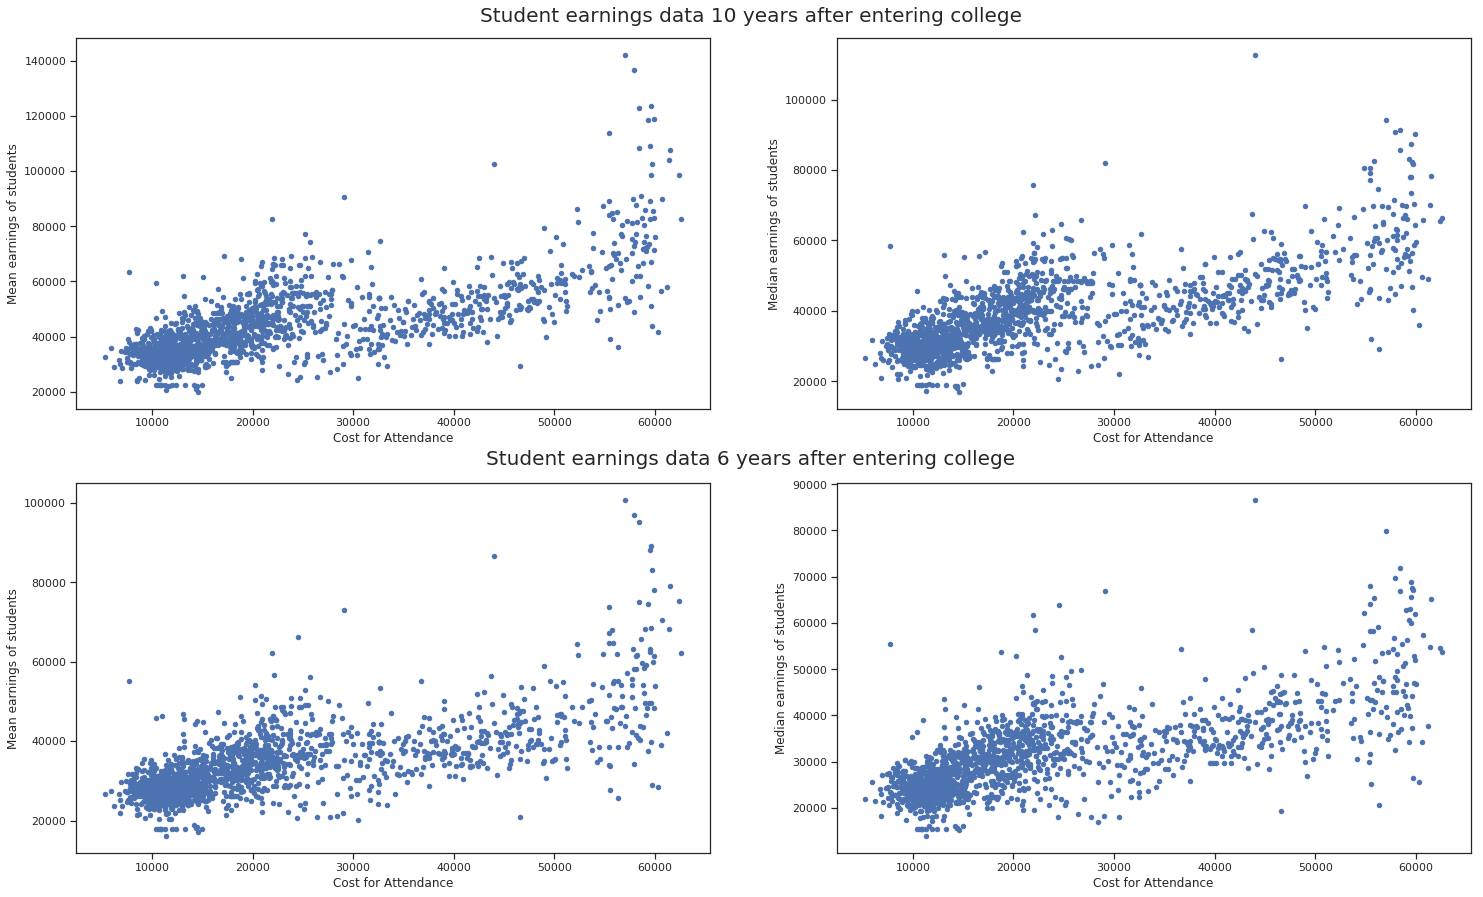

In [95]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,15))
ax = df.plot.scatter(x=avg_cost_of_attendance_academic_institutions,y=mean_earnings_of_students_wne_10y_after_entry, ax=axes[0,0])
ax.set_xlabel('Cost for Attendance')
ax.set_ylabel('Mean earnings of students')
ax = df.plot.scatter(x=avg_cost_of_attendance_academic_institutions,y=median_earnings_of_students_wne_10y_after_entry, ax=axes[0,1])
ax.set_xlabel('Cost for Attendance')
ax.set_ylabel('Median earnings of students')

ax = df.plot.scatter(x=avg_cost_of_attendance_academic_institutions,y=mean_earnings_of_students_wne_6y_after_entry, ax=axes[1,0])
ax.set_xlabel('Cost for Attendance')
ax.set_ylabel('Mean earnings of students')
ax = df.plot.scatter(x=avg_cost_of_attendance_academic_institutions,y=median_earnings_of_students_wne_6y_after_entry, ax=axes[1,1])
ax.set_xlabel('Cost for Attendance')
ax.set_ylabel('Median earnings of students')

# Add plot title for the entire subplot row
fig.text(0.5, 0.90, 'Student earnings data 10 years after entering college', ha='center', va='center', fontsize=20)
fig.text(0.5, 0.49, 'Student earnings data 6 years after entering college', ha='center', va='center', fontsize=20)

f1 = plt.gcf()

In [96]:
# count how many institutions per state
state_labels = set(df[state])
state_institution_count = {};
state_institutions = {};
state_list = [];
for label in state_labels:
    count = len(df[df[state]==label])
    state_institution_count[label] = count
    state_institutions[label] = df.loc[df[state] == label]
    state_list.append((label, count))


In [97]:
sorted_state_list = sorted(tuple_list, key=lambda tup: tup[1], reverse=True)


In [98]:
public_institutions = df[df[ownership] == 1]
private_institutions = df[df[ownership] != 1]
mean_public_10y = public_institutions[mean_earnings_of_students_wne_10y_after_entry].mean()
mean_private_10y = private_institutions[mean_earnings_of_students_wne_10y_after_entry].mean()

mean_public_6y = public_institutions[mean_earnings_of_students_wne_6y_after_entry].mean()
mean_private_6y = private_institutions[mean_earnings_of_students_wne_6y_after_entry].mean()

print(ttest_ind(public_institutions[mean_earnings_of_students_wne_10y_after_entry], private_institutions[mean_earnings_of_students_wne_10y_after_entry]))
print(ttest_ind(public_institutions[mean_earnings_of_students_wne_6y_after_entry], private_institutions[mean_earnings_of_students_wne_6y_after_entry] ))

Ttest_indResult(statistic=-19.352536308497477, pvalue=4.4658330544652271e-75)
Ttest_indResult(statistic=-18.995241771645855, pvalue=1.1796391949227921e-72)


In [99]:
print('meanpublic_10y:',mean_public_10y)
print('meanprivate_10y:',mean_private_10y)

print('meanpublic_6y:',mean_public_6y)
print('meanprivate_6y:',mean_private_6y)


meanpublic_10y: 40029.8736462
meanprivate_10y: 53150.8333333
meanpublic_6y: 31751.3537906
meanprivate_6y: 40678.3333333


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

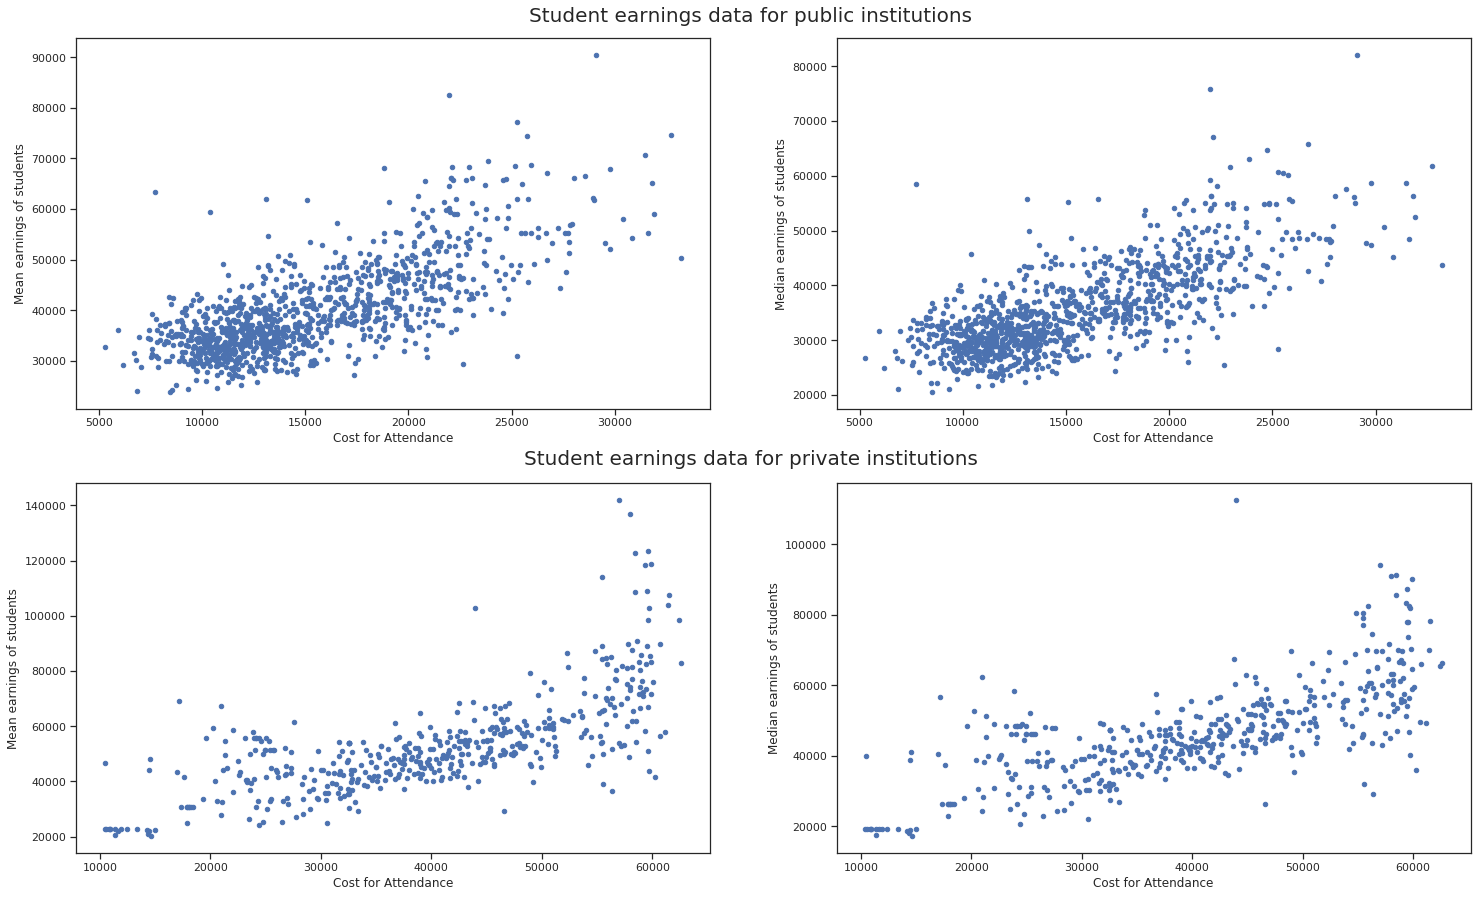

In [100]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(25,15))
ax = public_institutions.plot.scatter(x=avg_cost_of_attendance_academic_institutions,y=mean_earnings_of_students_wne_10y_after_entry, ax=axes[0,0])
ax.set_xlabel('Cost for Attendance')
ax.set_ylabel('Mean earnings of students')
ax = public_institutions.plot.scatter(x=avg_cost_of_attendance_academic_institutions,y=median_earnings_of_students_wne_10y_after_entry, ax=axes[0,1])
ax.set_xlabel('Cost for Attendance')
ax.set_ylabel('Median earnings of students')

ax = private_institutions.plot.scatter(x=avg_cost_of_attendance_academic_institutions,y=mean_earnings_of_students_wne_10y_after_entry, ax=axes[1,0])
ax.set_xlabel('Cost for Attendance')
ax.set_ylabel('Mean earnings of students')
ax = private_institutions.plot.scatter(x=avg_cost_of_attendance_academic_institutions,y=median_earnings_of_students_wne_10y_after_entry, ax=axes[1,1])
ax.set_xlabel('Cost for Attendance')
ax.set_ylabel('Median earnings of students')

# Add plot title for the entire subplot row
fig.text(0.5, 0.90, 'Student earnings data for public institutions', ha='center', va='center', fontsize=20)
fig.text(0.5, 0.49, 'Student earnings data for private institutions', ha='center', va='center', fontsize=20)

f2 = plt.gcf()

In [101]:
md_earning6 = df['MD_EARN_WNE_P6'].mean()
avg_earning6 = df['MN_EARN_WNE_P6'].mean()
avg_cost = df['COSTT4_A'].mean()

cost_leaving = 4*avg_cost
md_dbt_leaving = df['GRAD_DEBT_MDN'].mean()
#Plotting with interest
y = [0]*8
y[0]= md_dbt_leaving
for i in range(1,8):
    y[i]= y[i-1]*(1.055)-.10*(md_earning6)
    

#without interest the years to recoup investement
yrs_in= cost_leaving/md_earning6
#This is about 3


Text(0, 0.5, 'Debt in Dollars')

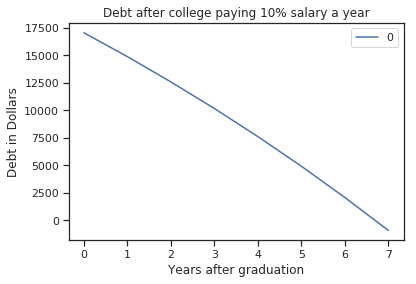

In [102]:
yf = pd.DataFrame(y)
yf.plot(title= 'Debt after college paying 10% salary a year')
plt.xlabel('Years after graduation')
plt.ylabel('Debt in Dollars')

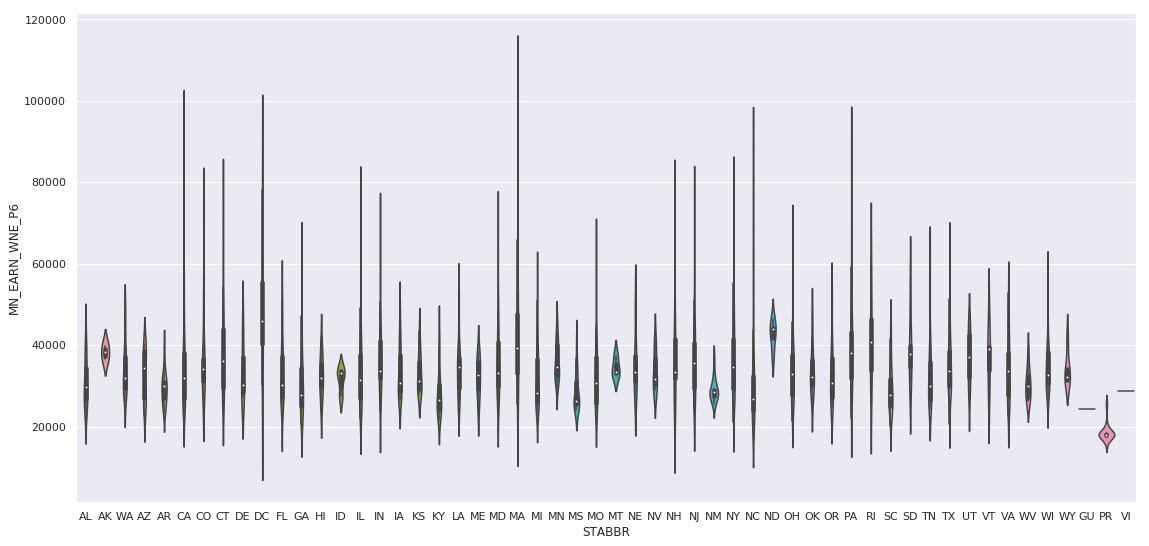

In [103]:
sns.set(rc={'figure.figsize':(19,9)})
sns.violinplot(x= df["STABBR"],y=df["MN_EARN_WNE_P6"])